En esta fase, conocida como ingeniería de características (FE - Feature Engineering):

Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático. El procesamiento puede incluir:
Generación de nuevas características
Discretización o binning
Codificación (ordinal, one hot,…)
Escalamiento (normalización, estandarización, min – max,…)
Transformación (logarítmica, exponencial, raíz cuadrada, Box – Cox, Yeo – Johnson,…)
* Todas las decisiones y técnicas empleadas deben ser justificadas.

 

Además, se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento. Los ejemplos siguientes son ilustrativos, pero no exhaustivos, de lo que se podría aplicar:
Umbral de varianza
Correlación
Chi-cuadrado
ANOVA
Análisis de componentes principales (PCA)
Análisis factorial (FA)
* Es necesario fundamentar los métodos ejecutados.

 

Incluir conclusiones de la fase de "Preparación de los datos" en el contexto de la metodología CRISP-ML.

## Equipo 7:

- Luis Salomon Flores Ugalde A00817435

### Importaciones

In [3]:
import pandas as pd
import torch
from PIL import Image
from jupyterthemes import jtplot
import os
import dlib
import time
#from mtcnn import MTCNN
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from datetime import date
import random
from torchvision.utils import save_image
import pickle

jtplot.style()

## Importación de Utilidades


In [4]:

from utils.plot import show_images

### Preprocessing

In [5]:
torch.cuda.is_available()
num_workers = os.cpu_count()
print(num_workers)

12


In [6]:
dataset_name = 'KnightX_exp_dataset'
data_dir = "/Users/lsfu/Desktop/MNA/Integrador/MTTX/data"
dataset_full =  os.path.join(data_dir, dataset_name, 'data')
prepro_dir = os.path.join(data_dir, dataset_name, 'preprocess')
today = date.today()
date_str = today.strftime("%d_%m_")


# Feature Engineering

## Datos crudos  / Características

CLAHE fue elegido porque:
- Es una técnica adaptativa que mejora el contraste sin amplificar demasiado el ruido.  
- Evita la pérdida de información en zonas homogéneas, a diferencia de otros métodos como HE o AHE.  
- Es robusto frente a variaciones de iluminación, lo cual es crucial en reconocimiento de expresiones faciales.  

Gamma Correction podría ser una opción si solo se tratase de corregir iluminación pero queremos resaltar detalle.



### **CLAHE VS otras técnicas de mejora de imágenes**  

Esta tabla compara **CLAHE** con otras transformaciones de mejora de imágenes que podrían haberse utilizado en el preprocesamiento para reconocimiento de expresiones faciales.

| **Técnica** | **Descripción** | **Ventajas**                                                                                                                      | **Desventajas**                                                                                                                   | **Adecuado para reconocimiento de expresiones?**                                                                       |
|------------|---------------|-----------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------|
| **CLAHE (Contrast Limited Adaptive Histogram Equalization)** | Mejora el contraste local en áreas pequeñas de la imagen, limitando la amplificación del ruido. | - Mejora detalles en regiones clave del rostro.<br>- Reduce impacto de iluminación desigual.<br>- Evita sobreajuste de contraste. | - Puede exagerar el ruido en imágenes de baja calidad.<br>- Convierte la imagen a escala de grises.                               | Mejora visibilidad de rasgos faciales sin distorsionar la imagen.                                                      |
| **Histogram Equalization (HE)** | Ajusta la distribución de los píxeles en toda la imagen para mejorar el contraste. | - Método simple y rápido.<br>- Mejora visibilidad de áreas oscuras o muy iluminadas.                                              | - Puede sobreajustar y distorsionar los colores.<br>- No mantiene el control sobre el ruido en imágenes faciales.                 | **No recomendado**, ya que puede generar cambios bruscos de color y afectar la interpretación del modelo.              |
| **Gamma Correction** | Ajusta el brillo de la imagen mediante una transformación no lineal controlada por un parámetro gamma. | - Útil para normalizar imágenes con variaciones de iluminación.<br>- Mantiene información de color.                               | - No mejora detalles en sombras profundas como lo hace CLAHE.<br>- No es adaptativo (requiere ajuste manual del parámetro gamma). | **Podría funcionar**, pero no es óptimo para destacar detalles.                                                        |
| **Adaptive Histogram Equalization (AHE)** | Similar a CLAHE pero sin límite de contraste, lo que permite una mejora más extrema. | - Resalta detalles en imágenes con bajo contraste.<br>- Funciona bien en iluminación no homogénea.                                | - Puede exagerar demasiado el contraste y amplificar ruido en áreas uniformes.                                                    | **No recomendado**, ya que puede introducir ruido y hacer que los modelos fallen en identificar expresiones naturales. |
| **Laplacian Filtering** | Usa un filtro de realce basado en diferencias de intensidad de píxeles para resaltar bordes y detalles. | - Aumenta definición de bordes faciales.<br>- Puede mejorar detección de características como cejas y boca.                       | - No es una técnica de mejora general, sino que solo resalta contornos.<br>- Puede hacer que la imagen pierda información tonal.  | **No recomendado**, ya que no mejora el contraste global de la imagen.                                                 |
| **Unsharp Masking** | Aumenta la nitidez de una imagen al resaltar diferencias de intensidad de píxeles. | - Puede mejorar la percepción de detalles sutiles en la cara.<br>- Control ajustable del nivel de nitidez.                        | - No soluciona problemas de bajo contraste.<br>- Puede generar artefactos si se aplica en exceso.                                 | Útil en combinación con otras técnicas, pero no como solución principal.                                               |

---


In [7]:
class CLAHEBaseTransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def apply_clahe(self, img_np):
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        return clahe.apply(img_gray)  # Apply CLAHE and keep single channel

    def __call__(self, img):
        img_np = np.array(img)
        img_clahe = self.apply_clahe(img_np)
        return Image.fromarray(img_clahe, mode="L")  # Ensure single-channel grayscale

class CLAHETransform(CLAHEBaseTransform):
    pass

class CLAHEUnsharpTransform(CLAHEBaseTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), unsharp_amount=1.5):
        super().__init__(clip_limit, tile_grid_size)
        self.unsharp_amount = unsharp_amount

    def apply_unsharp_masking(self, img_np):
        gaussian_blur = cv2.GaussianBlur(img_np, (0, 0), 2)
        return cv2.addWeighted(img_np, self.unsharp_amount, gaussian_blur, -0.5, 0)

    def __call__(self, img):
        img_np = np.array(img)
        img_clahe = self.apply_clahe(img_np)
        img_sharpened = self.apply_unsharp_masking(img_clahe)
        return Image.fromarray(img_sharpened, mode="L")  


class CLAHEUnsharpColorTransform(CLAHEBaseTransform):
    """
    NEW: Applies CLAHE + Unsharp Masking while PRESERVING COLOR (LAB color space).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), unsharp_amount=1.5):
        super().__init__(clip_limit, tile_grid_size)  
        self.unsharp_amount = unsharp_amount  

    def apply_clahe(self, img_np):
        """
        Applies CLAHE on the L (lightness) channel in LAB color space.
        """
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)  # Convert to LAB
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        l_clahe = clahe.apply(l)  

        return cv2.merge([l_clahe, a, b])  # Merge enhanced L with original A and B

    def apply_unsharp_masking(self, img_np):
        """
        Applies unsharp masking on the enhanced L channel.
        """
        l, a, b = cv2.split(img_np)  
        gaussian_blur = cv2.GaussianBlur(l, (0, 0), 2)  
        l_sharpened = cv2.addWeighted(l, self.unsharp_amount, gaussian_blur, -0.5, 0)  
        return cv2.merge([l_sharpened, a, b])  

    def __call__(self, img):
        img_np = np.array(img)  
        img_lab = self.apply_clahe(img_np)  
        img_lab_sharpened = self.apply_unsharp_masking(img_lab)  
        img_rgb = cv2.cvtColor(img_lab_sharpened, cv2.COLOR_LAB2RGB)  
        return Image.fromarray(img_rgb)  

resize_x = 640
resize_y = 640
data_transforms = transforms.Compose([
    #CLAHETransform(),  
    CLAHEUnsharpTransform(clip_limit=1.0, tile_grid_size=(32, 32), unsharp_amount=1.2),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.Resize((resize_x, resize_y)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])
data_transform_null = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    #transforms.Resize((resize_x, resize_y)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]) 

])
data_transform_basic = transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    #transforms.Resize((resize_x, resize_y)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

data_transform_color = transforms.Compose([
    CLAHEUnsharpColorTransform(clip_limit=2.0, tile_grid_size=(8, 8), unsharp_amount=1.5),  # LAB Color-Preserved
    #transforms.Resize((resize_x, resize_y)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])


In [8]:
#dftif = DataframeTorchImageFolder(dataset_full, data_transforms=None)
i_dataset = datasets.ImageFolder(dataset_full, transform=data_transforms)
og_dataset = datasets.ImageFolder(dataset_full, transform=data_transform_null)
clahe_dataset = datasets.ImageFolder(dataset_full, transform=data_transform_basic)
clahe_color_dataset = datasets.ImageFolder(dataset_full, transform=data_transform_color)

In [9]:
# Verificar ejemplos
print(f"Clases: {i_dataset.classes}")
print(f"Total de imágenes: {len(i_dataset)}")

# Mostrar un ejemplo de imagen transformada
img, label = i_dataset[0]
print(f"Label: {label}, Imagen transformada: {img.shape}")

Clases: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Total de imágenes: 2968
Label: 0, Imagen transformada: torch.Size([1, 1080, 1920])


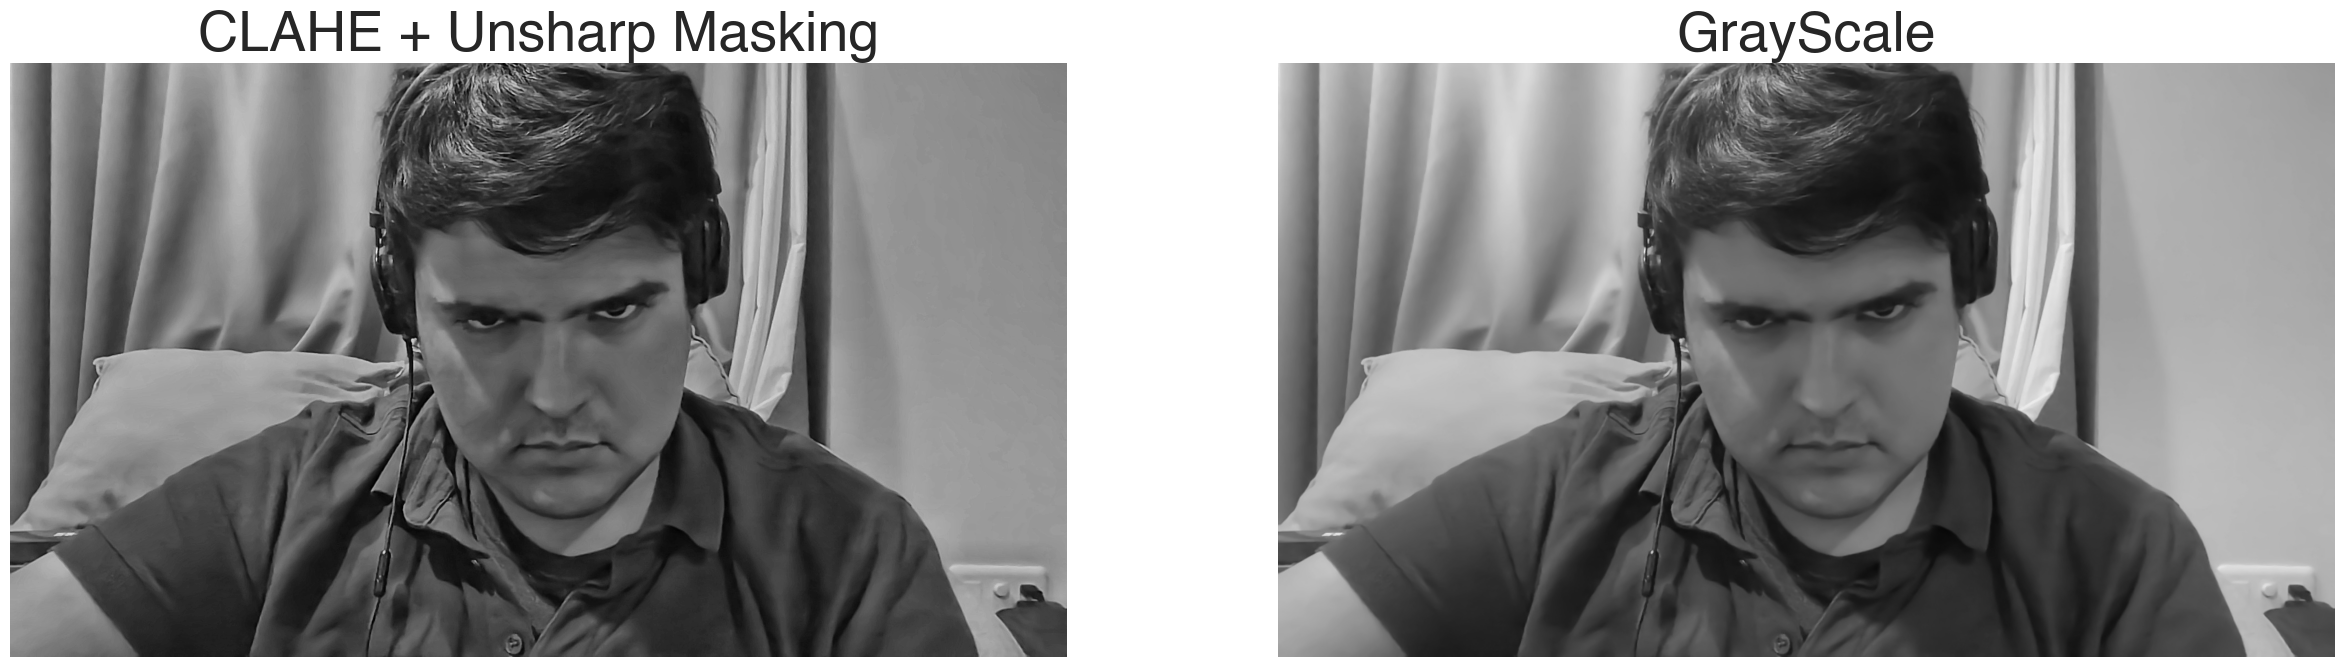

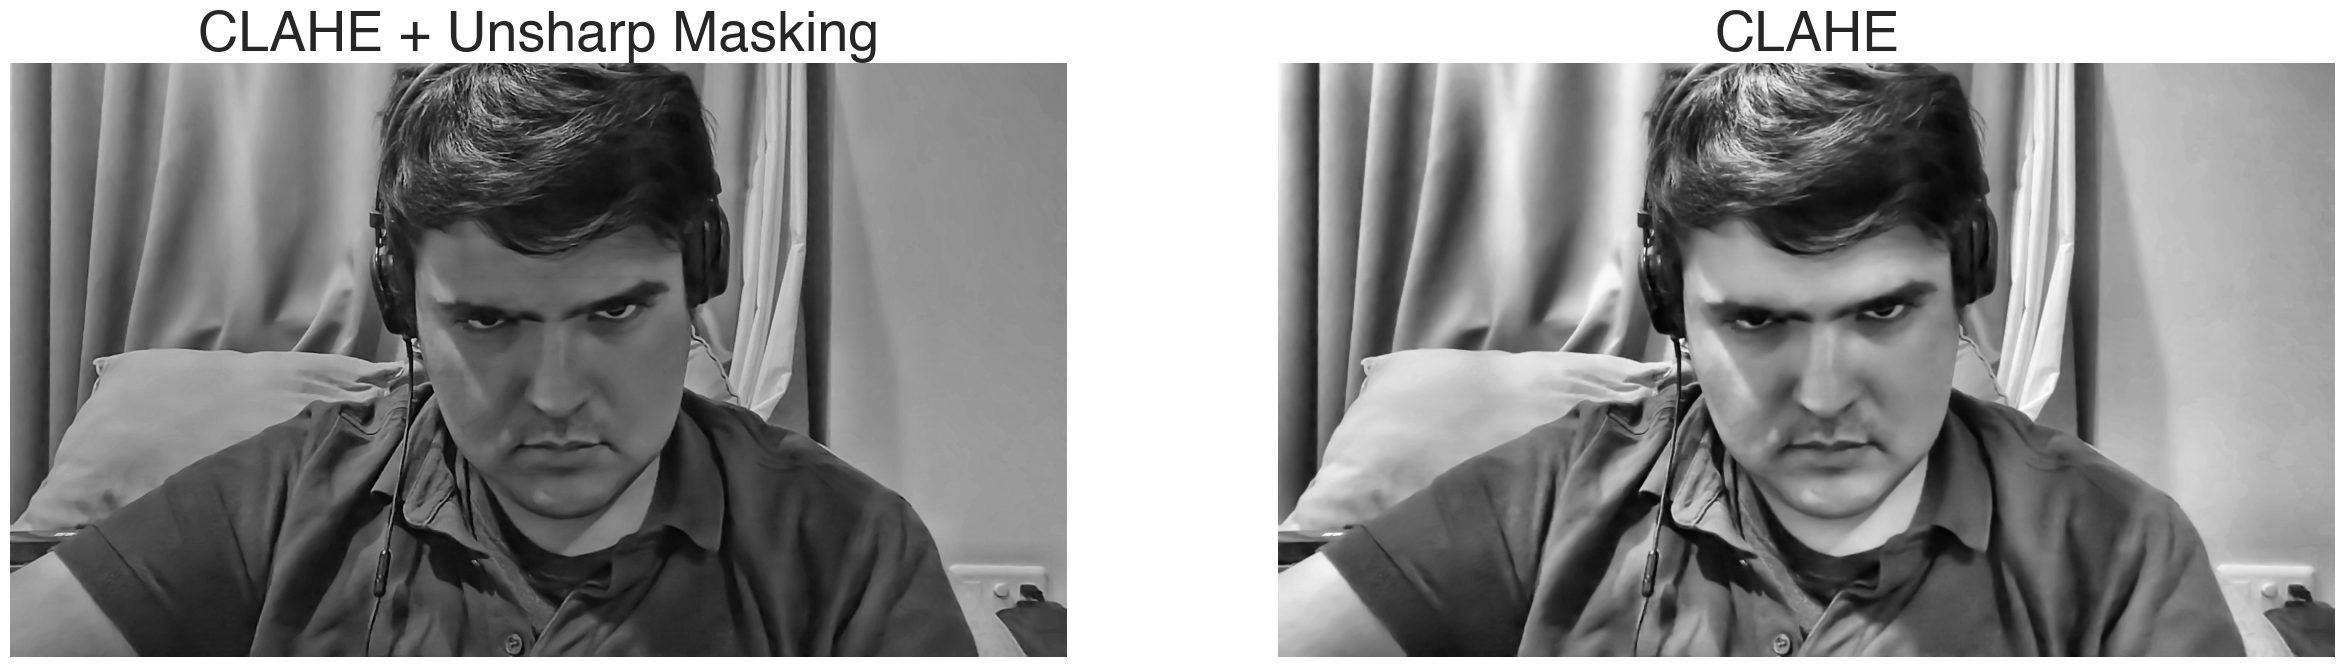

In [10]:
img2, _ = og_dataset[0]
img3, _ = clahe_dataset[0]
img4, _ = clahe_color_dataset[0]
show_images(img,img2, title1="CLAHE + Unsharp Masking", title2="GrayScale")
show_images(img,img3, title1="CLAHE + Unsharp Masking", title2="CLAHE")



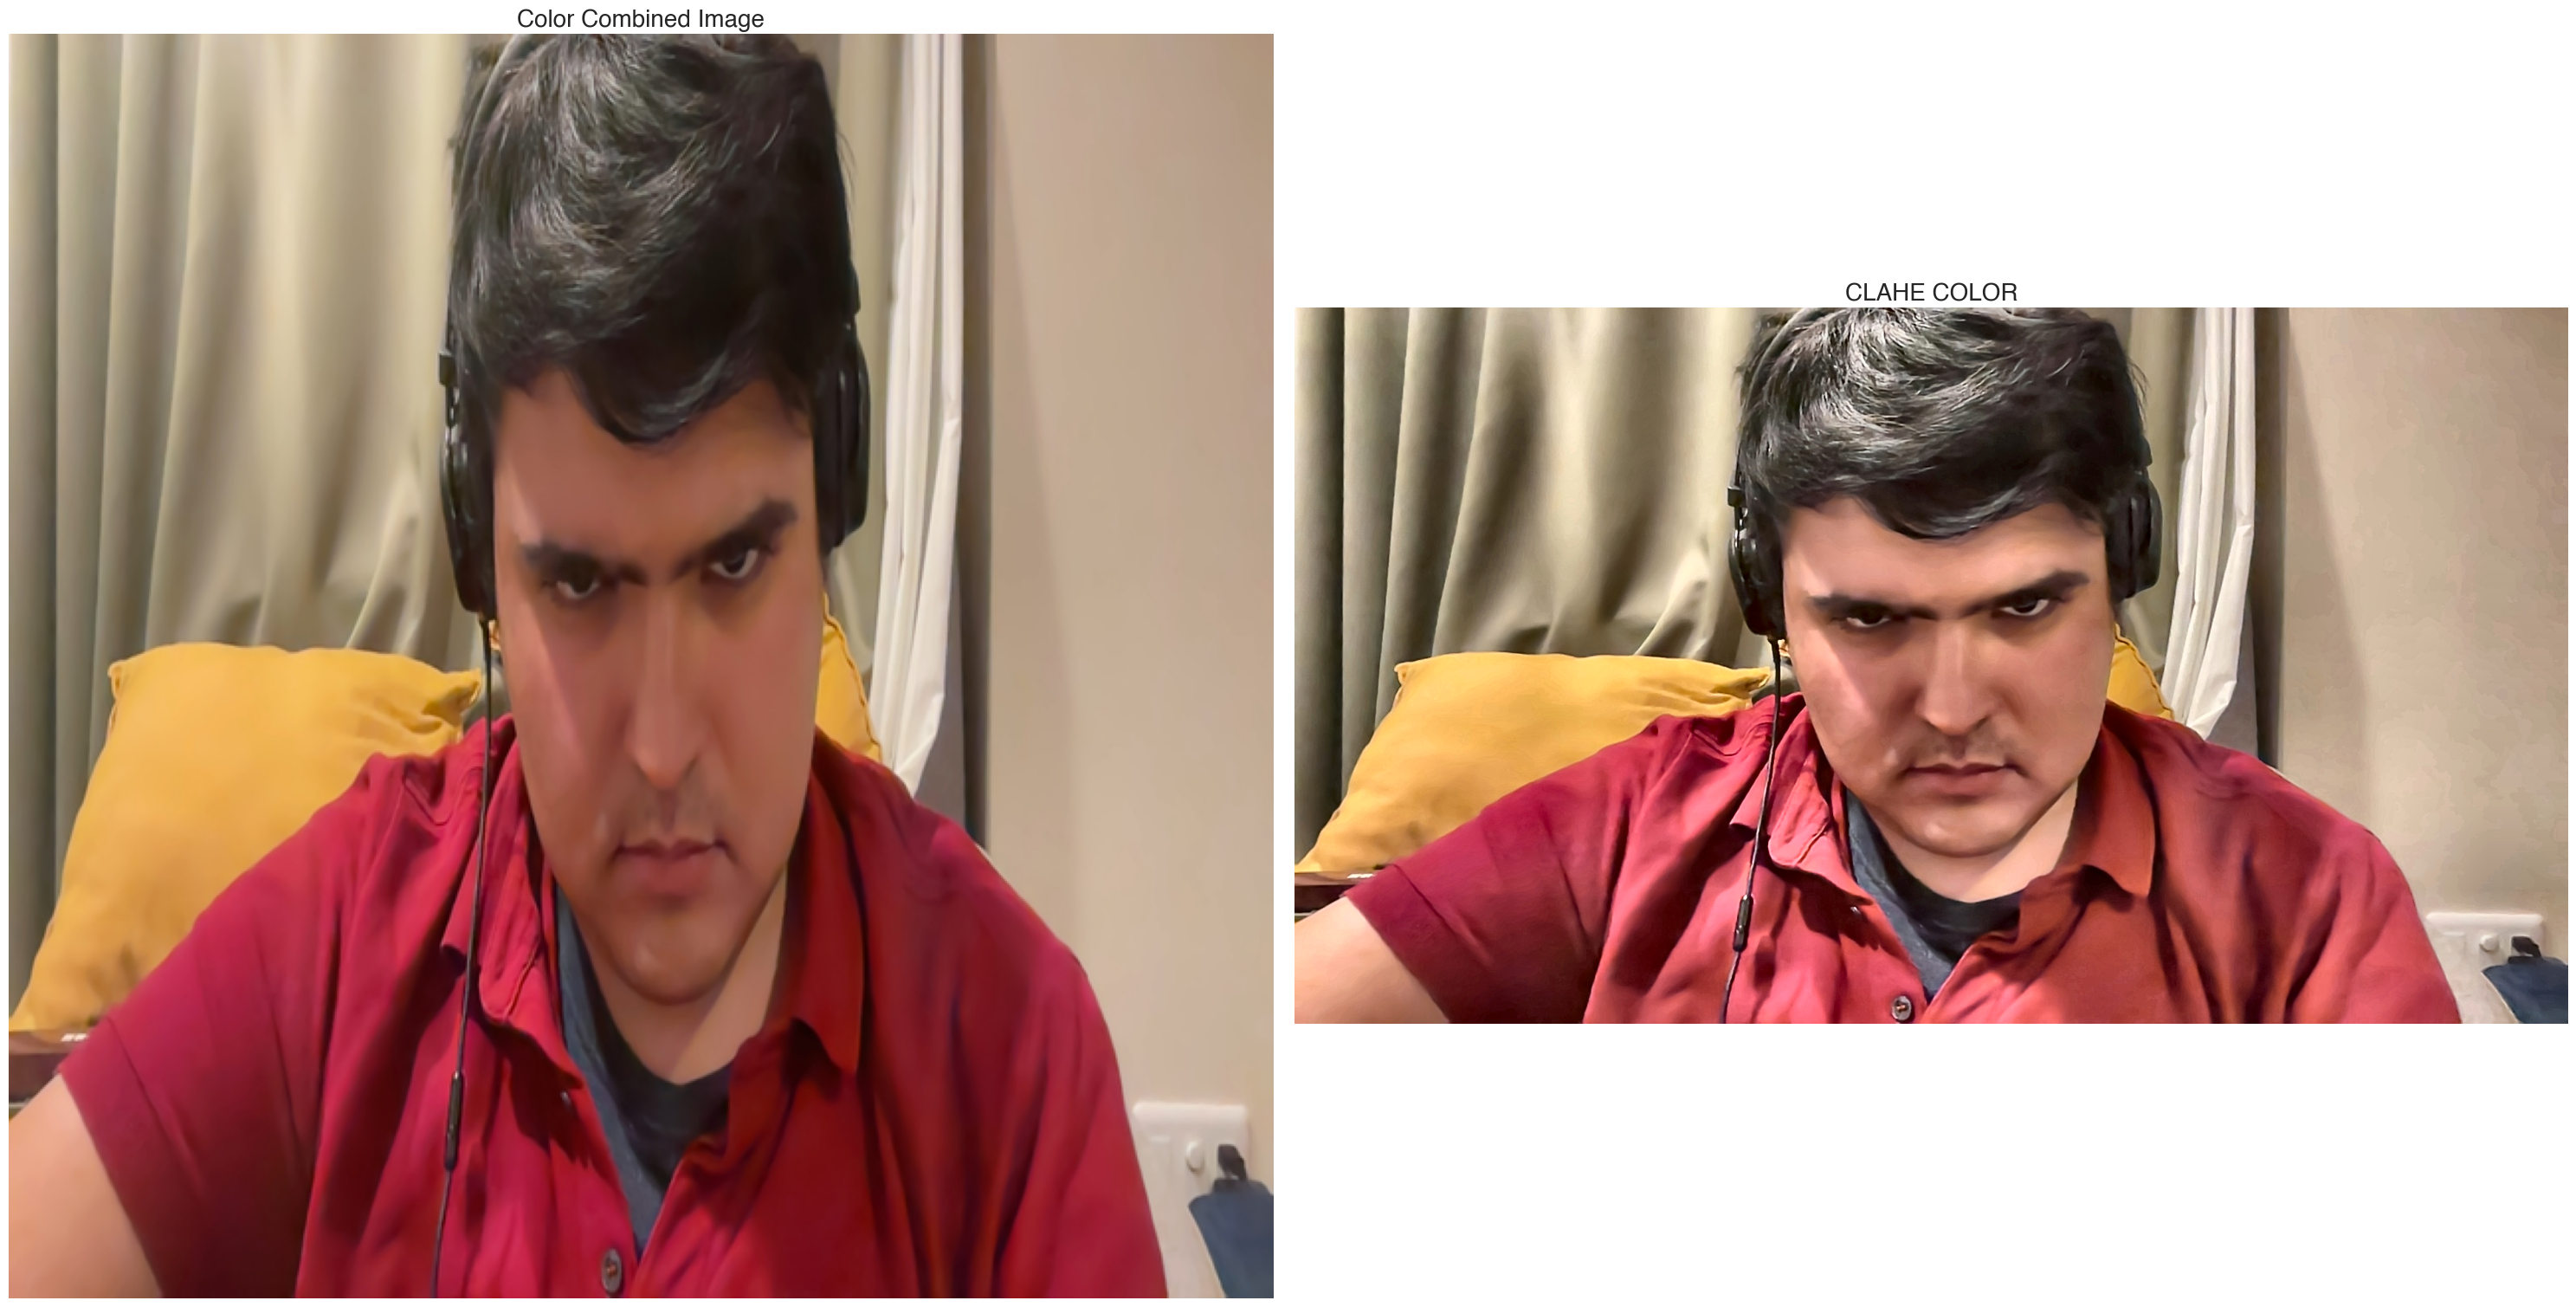

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

image_pil_te = Image.open(os.path.join(dataset_full,"angry","frame_1738316777391.jpg")).convert("RGB")
image_pil_te = image_pil_te.resize((resize_x, resize_y), Image.LANCZOS) 
# Displaying the resized grayscale + color image
axes[0].imshow(image_pil_te)
axes[0].set_title("Color Combined Image", fontsize=20, fontweight="bold")
axes[0].axis("off")

mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
image_tensor = img4 * std + mean
img_np = image_tensor.permute(1, 2, 0).numpy()

axes[1].imshow(img_np)
axes[1].set_title("CLAHE COLOR", fontsize=20, fontweight="bold")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### **CLAHE y Unsharp Masking**  

CLAHE, como se puede ver, es lo que hace la mayoría del cambio. El trabajo que se espera del **Unsharp Masking** es solo nitidez, un nivel más de detalle a los rasgos para el próximo punto.  
A su vez, tampoco queremos sobrecargar esto y hacerlo de más, pues podría resultar en problemas como artefactos.  

---

### **Impacto Esperado**  

- **Reducción de variabilidad en los datos de imagen.**  
- **Optimización del rendimiento del modelo.**  
- **Compatibilidad con técnicas de extracción de características.**  
    - Usarlos secuencialmente no sería posible sin reducir drásticamente el nivel de reconocimiento.  
      - MTCNN (Pytorch-Facenet) funciona mejor para detección de rostros generales.  
      - Dlib 68 es más preciso para la construcción de elementos faciales y soporta imágenes en escala de grises (directamente compatible con CLAHE).  
      - CLAHE afecta el rendimiento de MTCNN, pero Dlib sigue funcionando correctamente con imágenes procesadas en gris y con detalles aumentados.  
    - Se probó con un dataset de 2000 imágenes, y al aplicar CLAHE antes de la detección con MTCNN, la cantidad de rostros detectados se redujo a 100.  
    - Cualquier cambio en el contraste impide el funcionamiento correcto de modelos preentrenados de detección de rostro.  

- Utilizar Dlib para detección de landmarks faciales en imágenes con CLAHE, ya que soporta escala de grises y debería preservar la detección incluso con el preprocesamiento.  
- Usar MTCNN para detectar la caja del rostro en la imagen original sin modificaciones podria integrarse despues rápidamente a dlib. *Aprovechando la velocidad no usar el detector de "cara" y usar el predictor de puntos en vez.*



## Técnicas de Extracción de Características y Nuevas Características


---

### **Landmarks VS Otros Métodos**  

Para reconocimiento de expresiones, los landmarks faciales son una opción eficiente porque capturan la geometría del rostro sin depender de la iluminación o la textura. Se pueden complementar con otras técnicas basadas en imágenes completas para mejorar la precisión.  

| **Método** | **Descripción** | **Ventajas** | **Desventajas** | **Adecuado para reconocimiento de expresiones?** |
|------------|---------------|-------------|---------------|---------------------------------|
| **Landmarks faciales (MTCNN, dlib, OpenPose, etc.)** | Extrae puntos clave del rostro (ojos, nariz, boca, cejas, etc.), formando una representación geométrica. | Reduce dimensionalidad. Invariante a iluminación y textura. Facilita la extracción de características espaciales (distancias, ángulos). | No captura información de textura o color. Depende de la precisión del detector de landmarks. Puede fallar con rostros parcialmente visibles. | Sí, útil para analizar estructuras faciales clave sin requerir imágenes completas. |
| **Imagen completa (Raw Pixels / CNNs Directas)** | Utiliza la imagen sin procesar, permitiendo que una CNN aprenda características relevantes. | No requiere pasos adicionales de extracción. Captura detalles de textura, iluminación y color. | Requiere más datos y poder computacional. Sensible a iluminación y poses variables. | Sí, pero necesita grandes volúmenes de datos para entrenar correctamente. |
| **Histogramas de Gradientes Orientados (HOG)** | Extrae patrones de gradientes en la imagen para detectar bordes y formas. | Invariante a cambios de iluminación. Más rápido que redes neuronales profundas. | Menos preciso en variaciones de pose y expresiones complejas. No captura detalles internos del rostro. | No óptimo, ya que las expresiones pueden depender de sutilezas en la forma de los músculos faciales. |
| **Transformadas de Fourier/Wavelet** | Representa la imagen en el dominio de la frecuencia para detectar patrones globales. | Resistente al ruido y variaciones menores. Puede capturar cambios en textura. | No captura bien cambios locales de expresión. Requiere transformaciones adicionales para ser útil en aprendizaje profundo. | No recomendado, ya que las expresiones dependen de detalles espaciales específicos. |


---
### **Comparación Directa de Métodos de Landmarks Faciales**  

| **Modelo**  | **N° de Puntos** | **Compatibilidad con Escala de Grises** | **Soporta Resize** | **Precisión** | **Velocidad** | **Adecuado para Expresiones Faciales** |
|------------|------------------|--------------------------------|-------------------|--------------|-------------|------------------------------------|
| **MTCNN (Pytorch-Facenet)** | 5 puntos (ojos, nariz, boca) | No | Sí | Alta (para detección de rostro) | Rápida | Limitado, pocos puntos |
| **Dlib 68 landmarks** | 68 puntos (estructura detallada del rostro) | Sí | No (pierde precisión con resize) | Muy Alta | Más lento que MTCNN | Sí, ideal para expresiones |
| **OpenPose Face** | 70 puntos (versión extendida de Dlib) | Sí | Sí | Alta | Lento (más pesado) | Sí, pero requiere más GPU |
| **MediaPipe FaceMesh** | 468 puntos (malla detallada del rostro) | Sí | Sí | Altísima | Lenta en CPU, rápida en GPU | Sí, mejor para 3D |

**Conclusiones:**  
- MTCNN es útil para detectar rostros rápidamente, pero tiene muy pocos landmarks para expresiones.  
- Dlib 68 landmarks es más adecuado para expresiones faciales y soporta imágenes en escala de grises, lo que lo hace ideal para usar con CLAHE.  
- MTCNN no soporta escala de grises, por lo que su detección se ve afectada por CLAHE.  
- Dlib pierde precisión si la imagen es redimensionada después de la detección, por lo que debe aplicarse directamente sobre la imagen procesada sin cambios de tamaño.  
- Si se requiere mayor precisión o modelado en 3D, MediaPipe FaceMesh sería la mejor opción, pero es más costoso computacionalmente.  


Haar Cascades podría ser una opción si reducimos las gama de expresiones diversas que puede tener la misma categoría de expresiones. Aúnque a los ejemplos que se producen en el dataset no tendría problema si son muy claras. 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(select_largest=False, post_process=False, device=device)

Para facilitar el proceso. tenemos nuestra custom class que hace esto pero, no es posible terminar funcionalidades a tiempo. 

In [13]:
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    results = list(tqdm(
        executor.map(lambda idx: (idx, i_dataset.samples[idx][0], i_dataset[idx][1]), range(len(i_dataset))),
        total=len(i_dataset),
        desc="Extrayendo Index, File Paths, y Targets..."
    ))

df_id_targets = pd.DataFrame(results, columns=["idx", "file_path", "target"])


Extrayendo Index, File Paths, y Targets...: 100%|██████████| 2968/2968 [00:23<00:00, 128.01it/s]


In [14]:
def extract_landmarks_(idx, file_path):
    """Extracts bounding boxes and landmarks from an image using its file path."""
    try:
        image_pil = Image.open(file_path).convert("RGB") 
        #image_pil = image_pil.resize((resize_x, resize_y), Image.LANCZOS)  # Resize using PIL
        boxes, _, landmarks = mtcnn.detect(image_pil, landmarks=True)

        if boxes is None or landmarks is None or len(boxes) == 0:
            return idx, None, None  # No face detected

        return idx, boxes[0], np.array(landmarks[0], dtype=np.float32)  # Store only metadata
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return idx, None, None  # Handle image errors


def rm_similar_keep_lms_mtcnn_(dataset, dataframe, threshold=5.0):
    """Extracts landmarks, removes similar images, and stores only metadata."""
    removed_indices = []
    unique_indices = []
    unique_landmarks = []
    unique_boxes = []

    class_names = dataframe["target"].unique()

    for class_idx in class_names:
        class_entries = dataframe[dataframe["target"] == class_idx][["idx", "file_path"]].values.tolist()

        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(tqdm(
                executor.map(lambda entry: extract_landmarks_(entry[0], entry[1]), class_entries),
                total=len(class_entries),
                desc=f"Extracting Landmarks for {dataset.classes[class_idx]}"
            ))

        last_landmarks = None

        for idx, box, landmarks in results:
            if landmarks is None:
                removed_indices.append(idx) 
                continue

            if last_landmarks is not None:
                distances = np.linalg.norm(landmarks - last_landmarks, axis=1)
                mean_distance = np.mean(distances)

                if mean_distance < threshold:
                    removed_indices.append(idx)
                    continue  # Skip this image

            #metadatos.
            last_landmarks = landmarks
            unique_indices.append(idx)
            unique_landmarks.append(landmarks)
            unique_boxes.append(box)

    print(f"Removed {len(removed_indices)} duplicate images.")
    return unique_indices, unique_boxes, unique_landmarks, removed_indices

In [15]:
mtcnn_similarity_results = rm_similar_keep_lms_mtcnn_(i_dataset, df_id_targets,5)
u_indices, u_box, u_landmarks, rm_indices = mtcnn_similarity_results

Extracting Landmarks for surprise: 100%|██████████| 497/497 [00:43<00:00, 11.31it/s]

Removed 2484 duplicate images.


In [16]:
def tensor_to_image_gray(image_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    image_tensor_calc = image_tensor * std + mean
    img_np = image_tensor_calc.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return img_gray


def dlib_landmarks_and_mtcnn_box(indices, dataset, boxes, predictor):
    to_remove = []
    dlib_landmarks = []
    dlib_rect = []
    def extract_landmarks_dlib_mtcnn_box(idx, box):
        """Extrae landmarks usando Dlib con la caja de MTCNN como área de búsqueda."""
        try:
            image_tensor, _ = dataset[idx]
            gray = tensor_to_image_gray(image_tensor)
            
            x_min, y_min, x_max, y_max = map(int, box)
            face_region = gray[y_min:y_max, x_min:x_max]  # Recortar área de la cara
    
            dlib_rect = dlib.rectangle(0, 0, face_region.shape[1], face_region.shape[0])
            shape = predictor(face_region, dlib_rect)  # Detectar landmarks
    
            landmarks = [(p.x + x_min, p.y + y_min) for p in shape.parts()]
            
            return idx, landmarks, dlib_rect
    
        except Exception as e:
            print(f"Error en Dlib para {idx}: {e}")
            return idx, None # Box es face.rect

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(tqdm(
            executor.map(extract_landmarks_dlib_mtcnn_box, indices, boxes),
            total=len(indices), desc="Extracting 68 Dlib Landmarks"
        ))

    for idx, landmarks, rect in results:
        if landmarks is None:
            to_remove.append(idx)
            continue
        
        dlib_landmarks.append(landmarks)
        dlib_rect.append(rect)

    return dlib_landmarks,dlib_rect, to_remove 
        

In [17]:
model_folder = os.path.join(data_dir,"model")
model_filename = "shape_predictor_68_face_landmarks.dat"
model_path = os.path.join(model_folder, model_filename)

dlib_68_predictor = dlib.shape_predictor(model_path)
dlib_landmarks, dlib_rect, to_remove_check = dlib_landmarks_and_mtcnn_box(u_indices, i_dataset,u_box, dlib_68_predictor)

Extracting 68 Dlib Landmarks: 100%|██████████| 484/484 [00:07<00:00, 68.41it/s]


FPS Dlib 68 + despues de detección de rostro MTCNN PYTORCH

In [18]:

start = time.time()
gray = tensor_to_image_gray(img)

_x_min, _y_min, _x_max, _y_max = map(int, u_box[0])
_face_region = gray[_y_min:_y_max, _x_min:_x_max]  # Recortar área de la cara

_dlib_rect = dlib.rectangle(0, 0, _face_region.shape[1], _face_region.shape[0])
_shape = dlib_68_predictor(_face_region, _dlib_rect)  # Detectar landmarks

_landmarks = [(p.x + _x_min, p.y + _y_min) for p in _shape.parts()]
end = time.time()
print(1/(end-start))

54.506874593892135


In [19]:
len(to_remove_check)

0

In [20]:
len(u_indices)

484

In [21]:
def convert_to_dlib_shape(landmarks, bbox):
    """
    Convert a list of (x, y) tuples into a dlib full_object_detection shape object.
    
    Parameters:
    - landmarks: List of tuples [(x1, y1), (x2, y2), ...]
    - bbox: dlib.rectangle of the face bounding box (needed for dlib structure)
    
    Returns:
    - dlib.full_object_detection object
    """
    shape = dlib.full_object_detection(bbox, [dlib.point(x, y) for (x, y) in landmarks])
    return shape

64.69995526555293


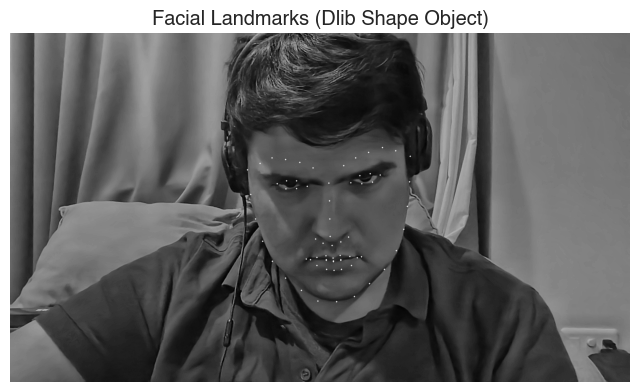

In [22]:

start = time.time()
img_gray = tensor_to_image_gray(img) # img, _ = i_dataset[idx]
dlib_shape = convert_to_dlib_shape(dlib_landmarks[0], dlib_rect[0])
end = time.time()

print(1/(end-start))
# Now you can use `part(n)`
for n in range(68):  
    x = dlib_shape.part(n).x
    y = dlib_shape.part(n).y
    cv2.circle(img_gray, (x, y), 2, (255, 0, 0), -1)  # Draw landmarks

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img_gray, cmap="gray")
plt.axis("off")
plt.title("Facial Landmarks (Dlib Shape Object)")
plt.show()

## RESULTADOS

Como se puede ver, aquí estamos integrando CLAHE, UNSHARP MASKING, Pytorch Facenet MTCNN para la cara principal como DETECTOR y el PREDICTOR de DLIB de 68 puntos para la cara. 

Dándonos una cantidad mucho mejor de detalle e información sobre las emociones representadas en la cara.
Esto claro depende del procesador del usuario y de ser posible como vemos anteriormente en mi lista comparativa, hay mejores y de más puntos que deberían de producir mejores resultados dado que se pueda hacer en un tiempo razonable.  

Aquí una comparación de rendimiento entre distintos métodos de detección facial en términos de velocidad (FPS - Frames Per Second) en diferentes resoluciones:

| **Detector de Rostros**           | **FPS (1080x1920)** | **FPS (720x1280)** | **FPS (540x960)** |
|----------------------------------|---------------------|--------------------|-------------------|
| facenet-pytorch (MTCNN en PyTorch) | 12.97               | 20.32              | 25.50             |
| facenet-pytorch (sin batch)       | 9.75                | 14.81              | 19.68             |
| **Dlib**                          | 3.80                | 8.39               | 14.53             |
| **MTCNN (implementación estándar)** | 3.04                | 5.70               | 8.23              |
Comparison of Face Detection Packages [1]

Estos resultados muestran que la implementación de **MTCNN en PyTorch** (facenet-pytorch) es significativamente más rápida en comparación con **Dlib** y la implementación tradicional de **MTCNN**, lo que la convierte en una mejor opción para tareas que requieren eficiencia computacional.

Quitando la carga de dlib normal para el rostro y enfocándolo en su modelo de landmarks mientras que el modelo de facenet se encarga de encontrar el rostro parece lo mejor. 
Como vemos en el resultado anterior  el dlib 68 de landmarks junto con el procesado de MTCNN + CLAHE y unsharp masking obtiene alrededor de **51 FPS**  es impactante aunque se le tiene que reducir unos cuantos para la aplicación minima de los algoritmos de transformación que se procesaron con anterioridad.


checkpoint 1

In [23]:

#len(i_dataset)
sal_ = os.path.join(prepro_dir,"salo") + "/test.pkl"
os.makedirs(os.path.dirname(sal_), exist_ok=True)
with open(sal_, "wb") as f:
    pickle.dump({
        "images": u_indices,          
        "box": u_box,
        "landmarks": u_landmarks, 
        "dlib_landmarks": dlib_landmarks, 
        "dlib_rect": dlib_rect, 
        "rm_files": list(rm_indices),  
    }, f)

In [24]:
original_images_dir = os.path.join(prepro_dir, 'clean_data', 'images')
processed_images_dir = os.path.join(prepro_dir, 'clean_data', 'processed_images')
landmarks_images_dir = os.path.join(prepro_dir, 'clean_data', 'landmarks')

os.makedirs(original_images_dir, exist_ok=True)
os.makedirs(processed_images_dir, exist_ok=True)
os.makedirs(landmarks_images_dir, exist_ok=True)

In [25]:
from torchvision.utils import save_image
def save_original_images(dataset, dataframe, u_indices, original_images_dir):
    
    # Extraer `targets` de `u_indices`
    targets_list = [dataframe.loc[dataframe['idx'] == idx, 'target'].values[0] for idx in u_indices]

    new_file_paths = {}  # Diccionario para almacenar las nuevas rutas de archivo

    def process_original_image(idx, target):
        """Guarda la imagen original redimensionada y actualiza la nueva ruta en el diccionario."""
        try:
            file_path = dataframe.loc[dataframe['idx'] == idx, 'file_path'].values[0]
            class_name = dataset.classes[target]  

            image_pil = Image.open(file_path).convert("RGB")
           # image_resized = image_pil.resize((resize_x, resize_y), Image.LANCZOS)

            class_folder = os.path.join(original_images_dir, class_name)
            os.makedirs(class_folder, exist_ok=True)

            save_path = os.path.join(class_folder, f"{idx}.jpg")
            new_file_paths[idx] = save_path
            image_pil.save(save_path)

        except Exception as e:
            print(f"Error guardando {idx}: {e}")

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        list(tqdm(
            executor.map(process_original_image, u_indices, targets_list), 
            total=len(u_indices), 
            desc="Guardando Imágenes Originales Redimensionadas"
        ))

    # Actualizar dataframe con la nueva columna "new_path"
    dataframe["new_path"] = dataframe["idx"].map(new_file_paths)

In [26]:

def save_processed_images(dataset, u_indices, processed_images_dir, num_workers=8):
    
    def save_processed_image(idx):
        """Guarda la imagen procesada desde el dataset."""
        try:
            image_tensor, target = dataset[idx]  
            img_gray = tensor_to_image_gray(image_tensor)
            
            class_name = dataset.classes[target]  
            class_folder = os.path.join(processed_images_dir, class_name)
            os.makedirs(class_folder, exist_ok=True)

            save_path = os.path.join(class_folder, f"{idx}.jpg")
            save_image(torch.tensor(img_gray).unsqueeze(0) / 255, save_path)
        except Exception as e:
            print(f"Error guardando {idx}: {e}")

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        list(tqdm(
            executor.map(save_processed_image, u_indices), 
            total=len(u_indices), 
            desc="Guardando Imágenes Procesadas"
        ))

In [27]:
def save_landmarked_images(dataset, dataframe, indices, landmarks, rectangles, landmarks_images_dir):

    def draw_landmarks(image, dlib_shape):
        """Draws Dlib's 68 landmarks on an image."""
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        for n in range(68):
            x, y = dlib_shape.part(n).x, dlib_shape.part(n).y
            cv2.circle(image, (x, y), 2, (0, 0, 255), -1)
        return image

    def save_landmarked_image(i, idx):
        """Loads the processed image, overlays Dlib landmarks, and saves it."""
  
        # Retrieve target class name
        target = dataframe.loc[dataframe['idx'] == idx, 'target'].values[0]
        class_name = dataset.classes[target]  
        img, _ = dataset[idx]
        img_gray = tensor_to_image_gray(img)
        dlib_shape = convert_to_dlib_shape(landmarks[i],  rectangles[i])

        img_landmarked = draw_landmarks(img_gray, dlib_shape)

        # Save the image with landmarks
        class_folder = os.path.join(landmarks_images_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

        save_path = os.path.join(class_folder, f"{idx}.jpg")
        cv2.imwrite(save_path, img_landmarked)
    
    for i, idx in tqdm(enumerate(indices), total=len(indices), desc="Saving Landmarked Images"):
        save_landmarked_image(i, idx)



In [28]:
save_original_images(i_dataset, df_id_targets, u_indices, original_images_dir)

Guardando Imágenes Originales Redimensionadas: 100%|██████████| 484/484 [00:01<00:00, 278.67it/s]


In [29]:
df_filtered = df_id_targets[df_id_targets["new_path"].notnull()].copy()

In [30]:
save_processed_images(i_dataset, u_indices, processed_images_dir)

Guardando Imágenes Procesadas: 100%|██████████| 484/484 [00:18<00:00, 25.79it/s]


In [31]:
save_landmarked_images(i_dataset, df_filtered, u_indices, dlib_landmarks, dlib_rect, landmarks_images_dir)

Saving Landmarked Images: 100%|██████████| 484/484 [00:23<00:00, 20.87it/s]


Todo proceso se va guardando y procesando de forma iterativa esto para dar lugar a la pipeline más adelante.



#### Muestra Final de landmarks

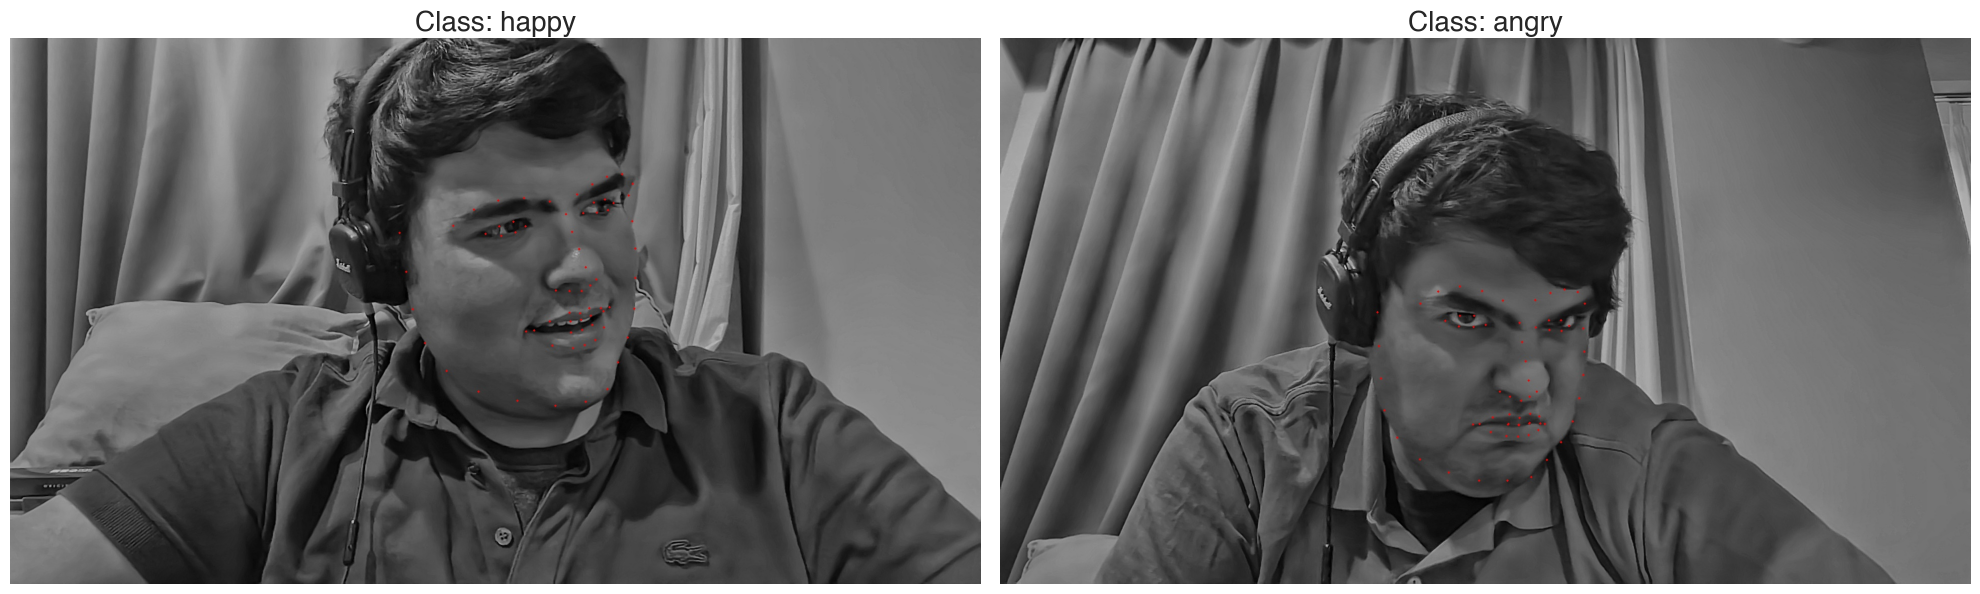

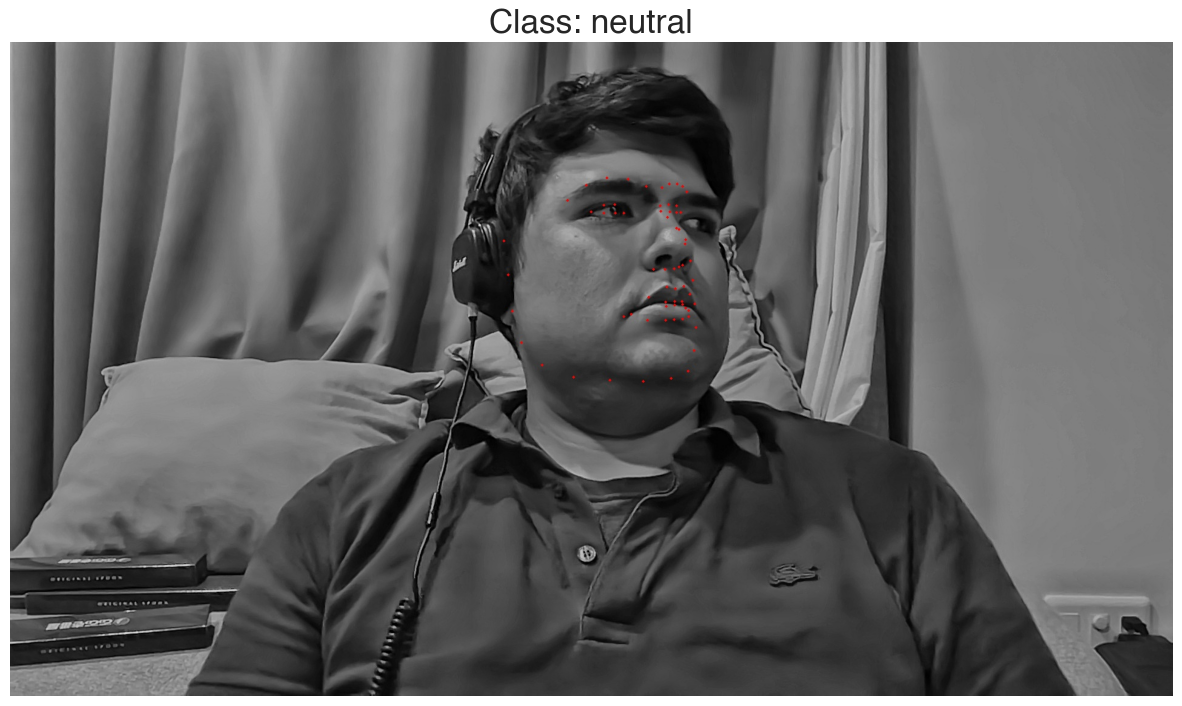

In [32]:


landmarks_dataset = datasets.ImageFolder(root=landmarks_images_dir, transform=transforms.ToTensor())

random_indices = random.sample(range(len(landmarks_dataset)), 3)
fig, axes = plt.subplots(1, 2, figsize=(20, 20)) 

for ax, idx in zip(axes, random_indices[:2]):
    img, label = landmarks_dataset[idx]  
    img = img.permute(1, 2, 0).numpy()  

    ax.imshow(img)  
    ax.set_title(f"Class: {landmarks_dataset.classes[label]}", fontsize=20, fontweight="bold")
    ax.axis("off")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 15)) 

img, label = landmarks_dataset[random_indices[2]]
img = img.permute(1, 2, 0).numpy()

ax.imshow(img)
ax.set_title(f"Class: {landmarks_dataset.classes[label]}", fontsize=24, fontweight="bold")
ax.axis("off")

plt.show()

## CONCLUSIONES Y RESULTADOS DE FEATURE ENGINERING 

De las conclusiones sobre el modelo son las mismas. Tenemos no solo la opción de tomar la imagen como tal y alimentarla de esa forma, ahora tenemos 68 landmarks, de los cuales posiblemente nos interesen solo los de ojos y boca y cejas  pero se pueden disminuir, cada punto es información que puede meterse al modelo en conjunto de la imagen. Podríamos como los ejemplos que se ponen anteriormente de forma similar, poner esta información en otro canal perceptible para el modelo y que pueda mejor diferenciar los rasgos de una expresión.

Lo que se hizo para este avance de forma de funciones escalables, para meter a pipelines o para escalar en procesamiento, todo lo cual cabe dentro de CRISP-ML y se prepara para la pipeline de pruebas:

- **Preprocesamiento de imágenes:**
  - **CLAHE  para mejorar el contraste de las imágenes.
  - **Unsharp Masking** para resaltar detalles finos y mejorar la nitidez.

- **Detección facial:**
  - **MTCNN (Multi-task Cascaded Convolutional Networks)** version de Facenet PyTorch para la detección inicial de rostros.
  - **Dlib 68-landmarks** en combinación con CLAHE y Unsharp Masking, utilizando la **bounding box de MTCNN** para evitar el uso del detector de rostros de Dlib y optimizar el rendimiento ya que es más rapido.

- **Filtrado y selección de características:**
  - Eliminación de imágenes redundantes basadas en la similitud de landmarks faciales.
    -  Como el dataset se alimenta con clips, lo unico que importa de cada uno es que la emoción que representan se mantenga y porlo tanto solo queremos los frames más diferentes entre si.
  - Se descartan imágenes sin detección de rostro para evitar sesgos en el dataset. (debería ocurrir en la creación del dataset. Pero redundancía) 

Para soportar el por que apesar de que dlib tiene mejor sistema de cara y soporte para CLAHE decidí tomar MTCNN pytorch como vimos en la tabla anterior y en mi resultado de timepo de procesamiento de dlib + el procesado de MTCNN pytorch. 

Si quiero proporcionar el tracking inicial tengo que pensar que mi velocidad inicial por thread es alrededor de 13 FPS y dentro tenemos que correr otros procesos.  

**Con diferentes sets de videos y tamaños cuando el dataset crezca en las siguientes entregas, sera necesario hacer un escalamiento para el entrenamiento. Esto, sin embargo...no puede ser antes de procesar ninguna imagen pues los detectores no pueden manejar el resize**
**Una vez calculado todo, el resize debería calcularse manualmente para los landmarks. Las imágenes pueden hacer resize de forma normal** 

Referencias:

[1] T. Esler, "Comparison of Face Detection Packages," Kaggle, 2020. [En línea]. Disponible en: https://www.kaggle.com/code/timesler/comparison-of-face-detection-packages. [Accedido: 02-feb-2025].